In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define and use the graph

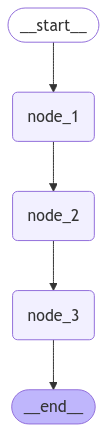

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(TypedDict):
    a: str


# Output from node_1 contains private data that is not part of the overall state
class Node1Output(TypedDict):
    private_data: str


# The private data is only shared between node_1 and node_2
def node_1(state: OverallState) -> Node1Output:
    output = {"private_data": "set by node_1"}
    print(f"Entered node `node_1`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Node 2 input only requests the private data available after node_1
class Node2Input(TypedDict):
    private_data: str


def node_2(state: Node2Input) -> OverallState:
    output = {"a": "set by node_2"}
    print(f"Entered node `node_2`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Node 3 only has access to the overall state (no access to private data from node_1)
def node_3(state: OverallState) -> OverallState:
    output = {"a": "set by node_3"}
    print(f"Entered node `node_3`:\n\tInput: {state}.\n\tReturned: {output}")
    return output


# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node_1)  # node_1 is the first node
builder.add_node(
    node_2
)  # node_2 is the second node and accepts private data from node_1
builder.add_node(node_3)  # node_3 is the third node and does not see the private data
builder.add_edge(START, "node_1")  # Start the graph with node_1
builder.add_edge("node_1", "node_2")  # Pass from node_1 to node_2
builder.add_edge(
    "node_2", "node_3"
)  # Pass from node_2 to node_3 (only overall state is shared)
builder.add_edge("node_3", END)  # End the graph after node_3
graph = builder.compile()

graph

In [3]:
# Invoke the graph with the initial state
response = graph.invoke(
    {
        "a": "set at start",
    }
)

print()
print(f"Output of graph invocation: {response}")

Entered node `node_1`:
	Input: {'a': 'set at start'}.
	Returned: {'private_data': 'set by node_1'}
Entered node `node_2`:
	Input: {'private_data': 'set by node_1'}.
	Returned: {'a': 'set by node_2'}
Entered node `node_3`:
	Input: {'a': 'set by node_2'}.
	Returned: {'a': 'set by node_3'}

Output of graph invocation: {'a': 'set by node_3'}
